In [1]:
### Importing packages

import pandas as pd
from glob import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import starry
from tqdm.notebook import tqdm
from scipy.interpolate import interp1d
from scipy.linalg import block_diag
import theano
import theano.tensor as tt
import theano.sparse as ts
import pickle
from matplotlib.colors import Normalize
import pymc3 as pm
import pymc3_ext as pmx
from scipy.signal import savgol_filter


np.random.seed(12)
starry.config.lazy = False
starry.config.quiet = True

In [2]:
### Import file

file_name = "fainterspectral-fits_6.pickle"
data = pd.read_pickle(file_name)

In [3]:
### Timestamps

t = np.array(
    [
        0.0,
        0.384384,
        0.76825872,
        1.15339656,
        1.5380364,
        1.92291888,
        2.30729232,
        2.69268336,
        3.07654752,
        3.46219464,
        3.8473428,
        4.23171624,
        4.61583456,
        4.99971048,
    ]
)


In [4]:
# Use the first epoch's wavelength array
lams = data["chiplams"][0]

In [5]:
# Interpolate onto that array
observed = np.empty((14, 4, 1024))
template = np.empty((14, 4, 1024))
broadened = np.empty((14, 4, 1024))
for k in range(14):
    for c in range(4):
        observed[k][c] = np.interp(
            lams[c],
            data["chiplams"][k][c],
            data["obs1"][k][c] / data["chipcors"][k][c],
        )
        template[k][c] = np.interp(
            lams[c],
            data["chiplams"][k][c],
            data["chipmodnobroad"][k][c] / data["chipcors"][k][c],
        )
        broadened[k][c] = np.interp(
            lams[c],
            data["chiplams"][k][c],
            data["chipmods"][k][c] / data["chipcors"][k][c],
        )

In [6]:
# Smooth the data and compute the median error from the MAD
smoothed = np.array(
    [savgol_filter(np.mean(observed[:, c], axis=0), 19, 3) for c in range(4)]
)
resid = observed - smoothed
error = 1.4826 * np.median(np.abs(resid - np.median(resid)))

In [7]:
# Clip outliers aggressively
level = 4
mask = np.abs(resid) < level * error
mask = np.min(mask, axis=0)

In [8]:
# Manually clip problematic regions
mask[0][np.abs(lams[0] - 2.290) < 0.00015] = False
mask[1][np.abs(lams[1] - 2.310) < 0.0001] = False
mask[3][np.abs(lams[3] - 2.33845) < 0.0001] = False
mask[3][np.abs(lams[3] - 2.340) < 0.0004] = False

In [9]:
# Get the final data arrays
pad = 100
wav = [None for n in range(4)]
wav0 = [None for n in range(4)]
flux = [None for n in range(4)]
mean_spectrum = [None for n in range(4)]
for c in range(4):
    wav[c] = lams[c][mask[c]][pad:-pad]
    flux[c] = observed[:, c][:, mask[c]][:, pad:-pad]
    wav0[c] = lams[c][mask[c]]
    mean_spectrum[c] = np.mean(template[:, c][:, mask[c]], axis=0)

In [10]:
# Set up a pymc3 model so we can optimize
with pm.Model() as model:

    # Dimensions
    ydeg = 10
    udeg = 1
    nc = 1
    nt = 14

    # Regularization
    flux_err = 0.02  # Eyeballed; doesn't matter too much since we're not doing posterior inference
    spectrum_sigma = 1e-2  # Hand-tuned; increase this to allow more departure from the template spectrum

    # Fixed
    vsini_max = 30000.0
    period = pm.math.constant(4.9)  # Crossfield et al. (2014)
    inc = pm.math.constant(70.0)  # Crossfield et al. (2014)

    # Free
    vsini = pm.Normal("vsini", mu=26100.0, sd=200)  # Crossfield et al. (2014)
    u1 = pm.Uniform("u1", 0.0, 1.0)  # Crossfield et al. (2014)

    # Deterministic
    veq = vsini / tt.sin(inc * np.pi / 180)
    theta = 360.0 * t / period

    # The surface map
    A = starry.DopplerMap(ydeg=ydeg).sht_matrix(smoothing=0.075)
    npix = A.shape[1]

    p = pm.Uniform("p", lower=0.0, upper=1.0, shape=(npix,))
    y = tt.dot(A, p)

    # The spectrum in each channel
    spectrum = [None for c in range(4)]
    for c in range(4):
        spectrum[c] = pm.Normal(
            f"spectrum{c}",
            mu=mean_spectrum[c],
            sd=spectrum_sigma,
            shape=mean_spectrum[c].shape,
        )

    # The continuum renormalization factor
    baseline = pm.Uniform("baseline", 0.3, 3.0, shape=(nt,), testval=0.65)

    # A small per-channel baseline offset
    offset = pm.Normal("offset", 0.0, 0.1, shape=(4,))

    # Compute the model & likelihood for each channel
    map = [None for c in range(4)]
    flux_model = [None for c in range(4)]
    for c in range(4):

        # Instantiate a map
        map[c] = starry.DopplerMap(
            ydeg=ydeg,
            udeg=udeg,
            nc=nc,
            veq=veq,
            inc=inc,
            nt=nt,
            wav=wav[c],
            wav0=wav0[c],
            lazy=True,
            vsini_max=vsini_max,
        )
        map[c][1] = u1
        map[c][:, :] = y
        map[c].spectrum = spectrum[c]

        # Compute the model
        flux_model[c] = offset[c] + tt.reshape(baseline, (-1, 1)) * map[
            c
        ].flux(theta=theta, normalize=False)

        # Likelihood term
        pm.Normal(
            f"obs{c}",
            mu=tt.reshape(flux_model[c], (-1,)),
            sd=flux_err,
            observed=flux[c].reshape(
                -1,
            ),
        )

In [11]:
# Optimization settings
lr = 1e-3
niter = 1000

In [12]:
# Optimize!
loss = []
best_loss = np.inf
map_soln = model.test_point
iterator = tqdm(
    pmx.optim.optimize_iterator(pmx.optim.Adam(lr=lr), niter, start=map_soln),
    total=niter,
    disable=os.getenv("CI", "false") == "true",
)
with model:
    for obj, point in iterator:
        iterator.set_description(
            "loss: {:.3e} / {:.3e}".format(obj, best_loss)
        )
        loss.append(obj)
        if obj < best_loss:
            best_loss = obj
            map_soln = point

  0%|          | 0/1000 [00:00<?, ?it/s]

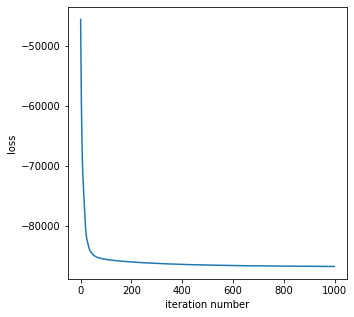

In [18]:
# Plot the loss
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.plot(loss)
ax.set_xlabel("iteration number")
ax.set_ylabel("loss")
fig.savefig("luhman16b_loss.jpg", bbox_inches="tight")

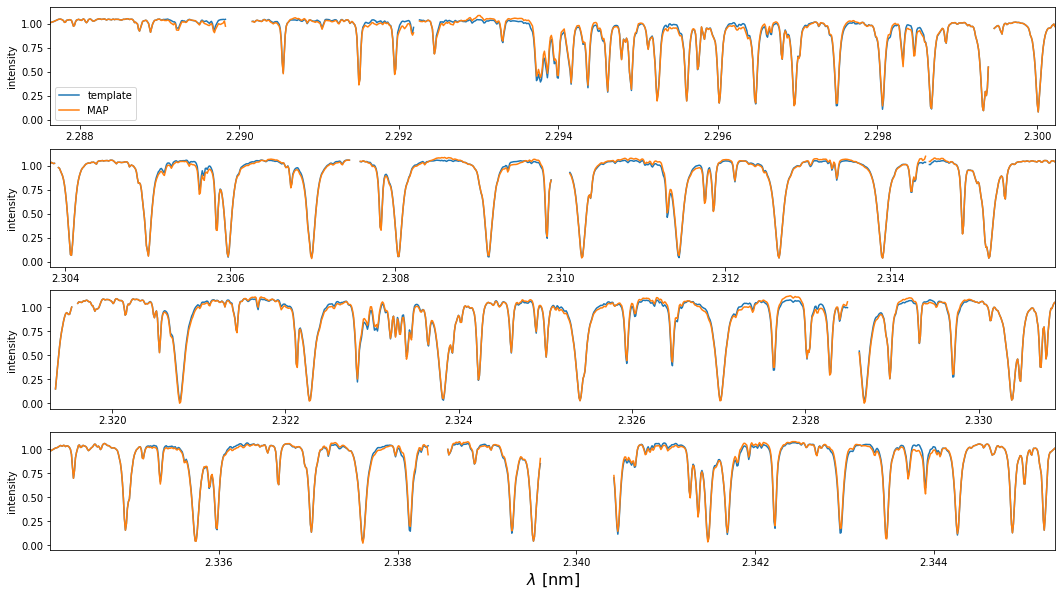

In [19]:
# Plot the rest frame spectra
fig, ax = plt.subplots(4, figsize=(18, 10), sharey=True)
with model:
    for c in range(4):
        # Mask breaks in the spectrum
        # so matplotlib doesn't linearly
        # interpolate
        dw = np.diff(wav0[c])
        dwm = np.mean(dw)
        dws = np.std(dw)
        x = np.array(wav0[c])
        x[1:][np.abs(dw - dwm) > 3 * dws] = np.nan
        ax[c].plot(x, mean_spectrum[c], label="template")
        ax[c].plot(
            x, pmx.eval_in_model(spectrum[c], point=map_soln), label="MAP"
        )
        ax[c].set_ylabel("intensity")
        ax[c].margins(0, None)
ax[0].legend(loc="lower left")
ax[-1].set_xlabel(r"$\lambda$ [nm]", fontsize=16)
fig.savefig("luhman16b_spectra.jpg", bbox_inches="tight")

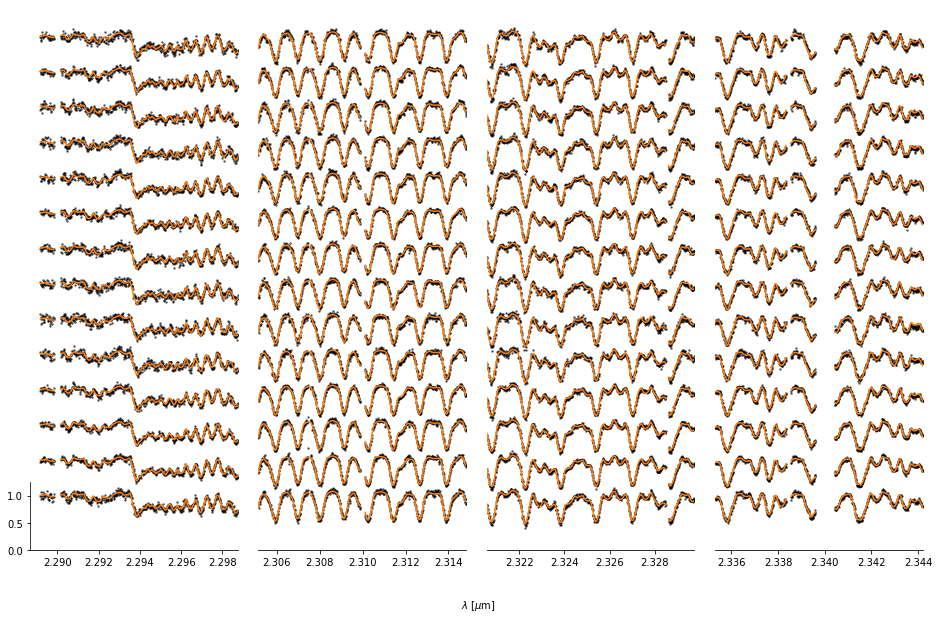

In [20]:
# Plot the data & model
fig, ax = plt.subplots(1, 4, figsize=(16, 10), sharey=True)
fig.subplots_adjust(wspace=0.1)
with model:
    for c in range(4):
        # Mask breaks in the spectrum
        # so matplotlib doesn't linearly
        # interpolate
        dw = np.diff(wav[c])
        dwm = np.mean(dw)
        dws = np.std(dw)
        x = np.array(wav[c])
        x[1:][np.abs(dw - dwm) > 3 * dws] = np.nan
        for k in range(14):
            ax[c].plot(
                x, 0.65 * k + flux[c][k], "k.", ms=3, alpha=0.5, zorder=-1
            )
            ax[c].plot(
                x,
                0.65 * k + pmx.eval_in_model(flux_model[c][k], point=map_soln),
                "C1-",
            )
    # Appearance hacks
    for c in range(4):
        if c > 0:
            ax[c].get_yaxis().set_visible(False)
        ax[c].spines["left"].set_visible(False)
        ax[c].spines["right"].set_visible(False)
        ax[c].spines["top"].set_visible(False)
        ax[c].margins(0, None)
        for tick in ax[c].get_xticklabels() + ax[c].get_yticklabels():
            tick.set_fontsize(10)
        ax[c].xaxis.set_major_formatter("{x:.3f}")
        ax[c].set_rasterization_zorder(0)
    ax[0].set_ylim(0.3, 10)
    ax[0].set_yticks([0, 0.5, 1.0])
    ax[0].set_xlim(ax[0].get_xlim()[0] - 0.0005, ax[0].get_xlim()[1])
    ax[0].set_ylim(*ax[0].get_ylim())
    x0 = ax[0].get_xlim()[0]
    y0 = ax[0].get_ylim()[0]
    ax[0].plot([x0, x0], [y0, 1.25], "k-", clip_on=False, lw=0.75)
    ax[0].set_xticks([2.290, 2.292, 2.294, 2.296, 2.298])
    ax[1].set_xticks([2.306, 2.308, 2.310, 2.312, 2.314])
    ax[2].set_xticks([2.322, 2.324, 2.326, 2.328])
    ax[3].set_xticks([2.336, 2.338, 2.340, 2.342, 2.344])
    plt.annotate(
        r"$\lambda$ [$\mu$m]",
        xy=(0.415, 0.03),
        xycoords="figure fraction",
        ha="center",
        clip_on=False,
    )
fig.savefig("luhman16b_data_model.jpg", bbox_inches="tight")

In [16]:
# Plot the MAP map
with model:
    y_map = pmx.eval_in_model(y, point=map_soln)
    inc_map = pmx.eval_in_model(inc, point=map_soln)
map_map = starry.Map(ydeg, inc=inc_map)
map_map[:, :] = y_map

# Save the MAP map (just in case we need it later)
np.savez("luhman16b_map.npz", y_map=y_map, inc_map=inc_map)

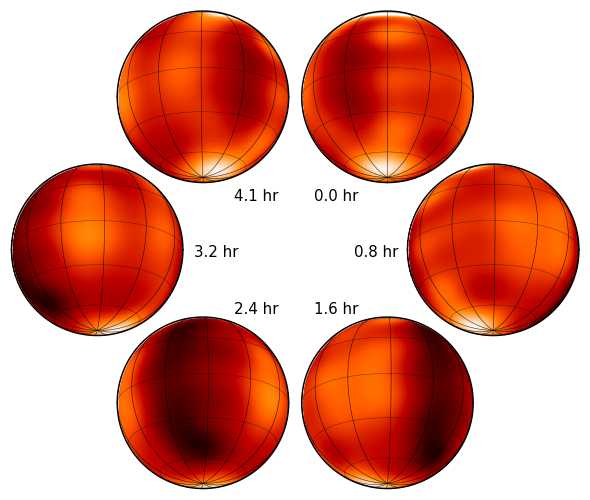

In [21]:
# Plot figure similar to that in Crossfield et al. (2014)
times = np.array([0.0, 0.8, 1.6, 2.4, 3.2, 4.1])
thetas = 360 * times / period
fig = plt.figure(figsize=(8, 8))
f = 1 / 0.64
ax = [
    plt.axes([0.3225 * f, 0.34 * f, 0.3125, 0.3125]),
    plt.axes([0.44 * f, 0.17 * f, 0.3125, 0.3125]),
    plt.axes([0.3225 * f, 0.0, 0.3125, 0.3125]),
    plt.axes([0.1175 * f, 0.0, 0.3125, 0.3125]),
    plt.axes([0.0, 0.17 * f, 0.3125, 0.3125]),
    plt.axes([0.1175 * f, 0.34 * f, 0.3125, 0.3125]),
]
norm = Normalize(vmin=0.45, vmax=0.56)
for n, axis in enumerate(ax):
    map_map.show(ax=axis, theta=thetas[n], cmap="gist_heat", norm=norm)
    axis.invert_yaxis()
    axis.invert_xaxis()
    angle = np.pi / 3 * (1 - n)
    plt.annotate(
        "{:.1f} hr".format(times[n]),
        xy=(0.515, 0.43),
        xycoords="figure fraction",
        xytext=(80 * np.cos(angle), 65 * np.sin(angle)),
        textcoords="offset points",
        va="center",
        ha="center",
        fontsize=15,
    )
fig.savefig("luhman16b_map.jpg", bbox_inches="tight")